# An extended evaluation of the results with various null-modelling appoaches

In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file_defaults()
from sklearn.preprocessing import StandardScaler
import nilearn
from tqdm import tqdm
from connattractor import network, analysis
%load_ext autoreload
%autoreload 1
%aimport connattractor.network
%aimport connattractor.analysis

## Fractional occupancy

### load empirical data

In [2]:
connfile = '../data_in/ex_connectome_partial_correlation.csv'

mtx = pd.read_csv(connfile).iloc[:, 1:]
mtx

,CER6_p,CER7ab,R_CERCR2_p,CER9_v,CER6_a,L_CERCR2_a,CER9_d,CER9_m,CER7b_m,L_CERCR2_p,...,LVISnet_vp,MVISnet_p,MVISnet_av,LVISnet_p,PVISnet_dm,PVISnet_vm,MVISnet_ad,VVISnet_l,LVISnet_DP,VVISnet_m
0,1.000000,0.023502,0.136701,0.008193,0.074264,0.021580,0.170827,0.028969,0.015883,0.130981,...,-0.002248,-0.008683,0.000152,0.035482,0.007705,-0.029055,0.009439,-0.001390,0.009582,0.007318
1,0.023502,1.000000,0.008167,0.024126,0.046648,0.050263,0.010915,0.070042,0.085829,-0.018248,...,0.033791,0.004000,0.011493,0.007582,-0.026080,0.008013,-0.009007,0.009144,0.001391,0.012831
2,0.136701,0.008167,1.000000,0.005056,0.062669,0.028488,0.041643,0.045169,0.112164,0.157129,...,-0.003300,0.016258,-0.011801,-0.001794,-0.000603,0.012350,-0.002757,-0.004949,-0.004858,-0.000633
3,0.008193,0.024126,0.005056,1.000000,-0.020494,-0.008721,-0.004522,0.203525,-0.003757,0.019182,...,0.021645,0.000472,-0.003774,0.003395,-0.032710,-0.015305,0.007360,0.004044,-0.011696,-0.001293
4,0.074264,0.046648,0.062669,-0.020494,1.000000,0.080293,0.024584,0.002491,-0.021720,0.042291,...,-0.020753,0.005295,-0.012844,-0.014833,0.009989,0.024167,-0.005186,-0.016061,0.010920,-0.007650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,-0.029055,0.008013,0.012350,-0.015305,0.024167,-0.007512,0.045950,0.010056,-0.006412,-0.000421,...,0.011186,0.215436,-0.011083,-0.003814,0.163692,1.000000,0.013773,0.049101,-0.028493,0.115196
118,0.009439,-0.009007,-0.002757,0.007360,-0.005186,-0.023476,-0.004195,-0.029927,-0.023948,-0.023841,...,-0.012657,0.258308,0.091981,0.007686,-0.001867,0.013773,1.000000,-0.013407,0.017465,0.032366
119,-0.001390,0.009144,-0.004949,0.004044,-0.016061,0.004057,0.002311,-0.022643,0.001888,-0.007811,...,0.139682,-0.014010,0.077810,0.079338,0.055300,0.049101,-0.013407,1.000000,0.081084,0.162297
120,0.009582,0.001391,-0.004858,-0.011696,0.010920,0.002928,-0.001322,0.004114,-0.006720,-0.008002,...,0.066451,0.001324,-0.001214,0.115287,0.089609,-0.028493,0.017465,0.081084,1.000000,0.000165


In [3]:
import os
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
root_dir = '../data_in/ex_timeseries/'
for f in glob(root_dir + 'bochum-???.tsv'):
    path, filename = os.path.split(f)
    ts = pd.read_csv(f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(path + '/FD_' + os.path.splitext(filename)[0] + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

perc. scrubbed: 0.515


### fcHNN

In [4]:
simresults_all = {}
hopfield_embeddings_all = {}

for noise in np.round(np.logspace(-1, 0, 8), 2):
    simresults_all[noise] = analysis.simulate_activations(mtx.values, noise_coef=noise, 
                                                          num_iter=100000, beta=0.04, random_state=2023)
    hopfield_embeddings_all[noise] = analysis.create_embeddings(simresults_all[noise], 
                                                                attractor_sample=len(all_ts),random_state=2023)

  0%|          | 82/100000 [00:00<02:02, 818.88it/s]

100%|██████████| 7200/7200 [06:33<00:00, 18.28it/s]


In [6]:
# time spent in state
emp_attractor_states = {}
for noise in np.round(np.logspace(-1, 0, 8), 2):
    tmp = []
    for s in tqdm(range(all_ts.shape[0])):
        tmp.append(hopfield_embeddings_all[noise].hopnet.update(all_ts[s, :])[0])
    emp_attractor_states[noise] = np.array(tmp)

100%|██████████| 7200/7200 [07:40<00:00, 15.65it/s]


In [21]:
simresults_all[0.37].states.shape


(100000, 122)

In [7]:
emp_attractor_labels = {}
for noise in np.round(np.logspace(-1, 0, 8), 2):
    emp_attractor_labels[noise] = []
    for i in range(emp_attractor_states[noise].shape[0]):
        for key in hopfield_embeddings_all[noise].attractors.keys():
            #print(hopfield_embeddings_all[noise].attractors[key], emp_attractor_states[noise][i,:])
            if np.allclose(hopfield_embeddings_all[noise].attractors[key], emp_attractor_states[noise][i,:], atol=0.001):
                emp_attractor_labels[noise].append(key)
                

## Now we use a phase randomized null model to generate a null-distribution for occupancy-similarity

noise: 0.1 : no multistability
noise: 0.14 : no multistability
noise: 0.19 : no multistability
noise: 0.27 stat: 852.3019025383169  p = 1.0


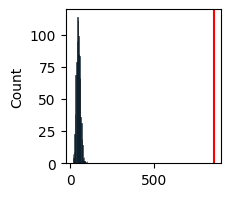

noise: 0.37 stat: 21.565370837595296  p = 0.0


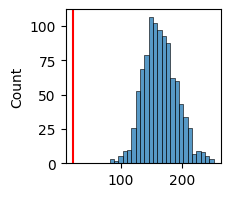

noise: 0.52 stat: 11.15915695780814  p = 0.0


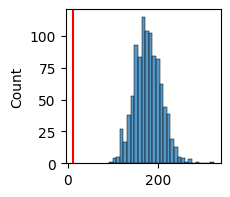

noise: 0.72 stat: 19.9599484603988  p = 0.0


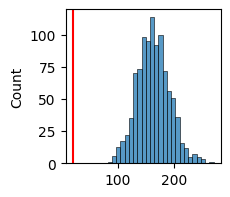

noise: 1.0 stat: 35.95363284185499  p = 0.0


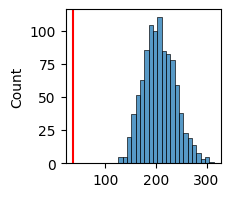

In [18]:
random = np.random.default_rng(42)

def phase_randomization(data):
    # Get the shape of the data
    num_samples, num_features = data.shape 
    # Create a copy of the data
    randomized_data = np.copy(data)
    # Iterate over each time-frame
    for i in range(num_samples):
        data = randomized_data[i, :]
        fft_data = np.fft.fft(data)
        phase = random.permutation(np.angle(fft_data)) # same perm for all region
        randomized_data[i, :] = np.real(np.fft.ifft(np.abs(fft_data) * np.exp(1j * phase)))
    
    return randomized_data

from scipy.stats import chisquare

n_perm =1000

for noise in np.round(np.logspace(-1, 0, 8), 2):
   

    # simulated
    sim_attractor_states = hopfield_embeddings_all[noise].attractor_sample
    label_sim, counts_sim = np.unique(sim_attractor_states, return_counts=True)
    if len(counts_sim)==1:
        print('noise:', noise, ': not heteroclinic')
        continue
    # empirical
    label_emp, counts_emp = np.unique(emp_attractor_labels[noise], return_counts=True)
    if len(counts_emp)==1:
        print('noise:', noise, ': not heteroclinic')
        continue
    true_test_stat = chisquare(counts_sim, counts_emp).statistic
   
    # null distribution for empirical
    test_stat_null = []
    for i in range(n_perm):
        
        all_ts_phaserand = phase_randomization(all_ts)
        
        embedded = hopfield_embeddings_all[noise].embedding_model.transform(all_ts_phaserand)[:, :2]
        attractor_labels = hopfield_embeddings_all[noise].attractor_model.predict(embedded)
        label_emp_shuffled, counts_emp_shuffled = np.unique(attractor_labels, return_counts=True)
        test_stat_null.append(chisquare(counts_sim, counts_emp_shuffled).statistic) # does this differ from empirical data?
    plt.figure(figsize=(2,2))
    sns.histplot(test_stat_null)
    plt.axvline(true_test_stat, color='red')
    print('noise:', noise, 'stat:', true_test_stat, ' p =', np.sum(np.array(test_stat_null) < true_test_stat) / n_perm)
    plt.show()

### Fractional occupancy is predicted for real data significantly better then for spatially phase randomized null data

## Another null model: sampling from a multivariate normal.

noise: 0.1 : not heteroclinic
noise: 0.14 : not heteroclinic
noise: 0.19 : not heteroclinic
noise: 0.27 stat: 852.3019025383169  p = 1.0


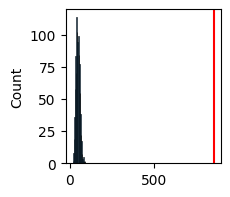

noise: 0.37 stat: 21.565370837595296  p = 0.007


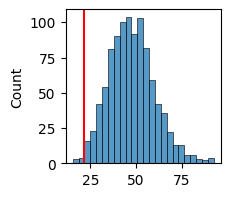

noise: 0.52 stat: 11.15915695780814  p = 0.015


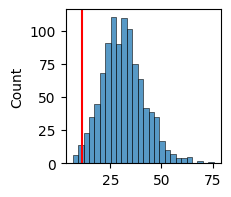

noise: 0.72 stat: 19.9599484603988  p = 0.719


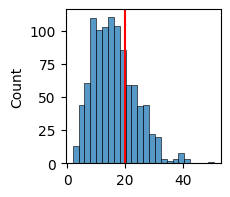

noise: 1.0 stat: 35.95363284185499  p = 0.999


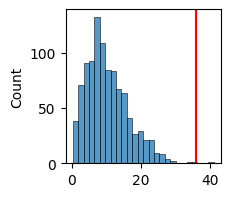

In [20]:
random = np.random.default_rng(42)

connfile = '../data_in/ex_connectome_partial_correlation.csv'
mtx = pd.read_csv(connfile).iloc[:, 1:]

from scipy.stats import chisquare

n_perm =1000

for noise in np.round(np.logspace(-1, 0, 8), 2):
   
    # simulated
    sim_states = hopfield_embeddings_all[noise].state_sample
    sim_embedded = hopfield_embeddings_all[noise].embedding_model.transform(sim_states)[:, :2]
    sim_attractor_states = hopfield_embeddings_all[noise].attractor_sample
    label_sim, counts_sim = np.unique(sim_attractor_states, return_counts=True)
    if len(counts_sim)==1:
        print('noise:', noise, ': not heteroclinic')
        continue
    
    label_emp, counts_emp = np.unique(emp_attractor_labels[noise], return_counts=True)
    true_test_stat = chisquare(counts_sim, counts_emp).statistic # the higher the stat the bigger the diff
   
    # null distribution for simulated
    test_stat_null = []
    for i in range(n_perm):
        
        all_ts_multivariate_normal = random.multivariate_normal(mean=np.repeat(0, mtx.shape[0]), 
                                                                cov=mtx.values, 
                                                                size=all_ts.shape[0])
        
        embedded = hopfield_embeddings_all[noise].embedding_model.transform(all_ts_multivariate_normal)[:, :2]
        # multivariate normal knows about the mean and std of the original distribution
        # we must give equal chances: rescale it to have the same range as the fcHNN simulated data
        embedded = (((embedded-np.mean(embedded)) / np.std(embedded)) * np.std(sim_embedded))+ np.mean(sim_embedded)
        attractor_labels = hopfield_embeddings_all[noise].attractor_model.predict(embedded)
        label_sim_null, counts_sim_null = np.unique(attractor_labels, return_counts=True)
        test_stat_null.append(chisquare(counts_sim_null, counts_emp).statistic) # does this differ from empirical data?
    
    plt.figure(figsize=(2,2))
    sns.histplot(test_stat_null)
    plt.axvline(true_test_stat, color='red')
    print('noise:', noise, 'stat:', true_test_stat, ' p =', np.sum(np.array(test_stat_null) < true_test_stat) / n_perm)
    plt.show()

### Fractional occupancy is predicted significantly better by fcHNN then by multivariate normal null data (with the functional covariance matrix) in case of sigma=0.37 and 0.52.

We choose sigma=0.37, which provides the best fit to the data.